In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
#nltk.download('punkt')

In [2]:
dataset = pd.read_pickle('other_xmltodict_all_major_fields.pkl')

In [3]:
### Drop the rows with no values in section_bodies
dataset = dataset[dataset['section_bodies'] != 'Null']
print("Without Null rows: " + str(len(dataset)))

Without Null rows: 2520


In [4]:
#only keep the SOR and CRC...SI are not included in the scope
dataset['regulation_type'].value_counts()

SOR     2265
SI       246
Null       9
Name: regulation_type, dtype: int64

In [5]:
dataset = dataset[dataset['regulation_type']!= 'SI']

In [6]:
dataset['regulation_type'].value_counts()

SOR     2265
Null       9
Name: regulation_type, dtype: int64

In [7]:
#Check the null regulation types...are they okay?
dataset[dataset['regulation_type']=='Null']

,consolidation_date,enabling_authority,enabling_type,file_name,instrument_number,language,last_modified_date,order_number,registration_date,regulation_maker,regulation_provision,regulation_type,repealed,section_bodies,section_labels,title
124,2018-06-11,"[{'@reference-type': 'act', '#text': 'APPROPRI...","[{'@reference-type': 'act', '#text': 'APPROPRI...","Consolidation_Regs_1.2.0/EN/C.R.C.,_c._340.xml","C.R.C., c. 340",en,2006-10-26,Null,Null,Null,Null,Null,False,"['In these Regulations, ""Minister"" means the M...","['2', '3', '4', '5']",REGULATIONS RESPECTING THE REIMBURSEMENT OF PR...
213,2018-06-11,WAR SERVICE GRANTS ACT,act,"Consolidation_Regs_1.2.0/EN/C.R.C.,_c._1600.xml","C.R.C., c. 1600",en,Null,Null,Null,Null,Null,Null,False,['Where an infant qualifies to receive the gra...,"['2', '3', '4', '5']",ORDER AUTHORIZING PERSONS TO RECEIVE A WAR SER...
650,2018-06-11,NUCLEAR SAFETY AND CONTROL ACT,act,Consolidation_Regs_1.2.0/EN/SOR-2000-205.xml,SOR/2000-205,en,Null,2000-785,2000-5-31,P.C.,"[{'@language-align': 'yes', '@format-ref': 'in...",Null,False,['These Regulations apply in respect of Class\...,"['2', '3', '4', '5', '6', '7', '8', '9', '10',...",CLASS II NUCLEAR FACILITIES AND PRESCRIBED EQU...
1133,2018-06-11,PILOTAGE ACT,act,"Consolidation_Regs_1.2.0/EN/C.R.C.,_c._1266.xml","C.R.C., c. 1266",en,Null,Null,Null,Null,Null,Null,False,"['In these Regulations,', 'The following areas...","['2', '3', '4', '4.1', '4.2', '4.3', '4.4', '4...","Regulations Respecting the Establishment, Oper..."
1977,2018-06-11,PRECIOUS METALS MARKING ACT,act,"Consolidation_Regs_1.2.0/EN/C.R.C.,_c._1302.xml","C.R.C., c. 1302",en,2005-7-22,Null,Null,Null,Null,Null,False,['The Minister of Consumer and Corporate Affai...,['2'],Order Designating the Minister for the Purpose...
3560,2018-06-11,COOPERATIVE CREDIT ASSOCIATIONS ACT,act,Consolidation_Regs_1.2.0/EN/SOR-2006-315.xml,SOR/2006-315,en,2007-1-25,2006-1440,2006-11-28,P.C.,Her Excellency the Governor General in Council...,Null,False,['For the purpose of subsection 145(1) of the ...,"['2', '3', '4', '5', '6', '7', '8', '9', '10']",Meetings and Proposals (Cooperative Credit Ass...
3660,2018-06-11,VETERANS’ LAND ACT,act,"Consolidation_Regs_1.2.0/EN/C.R.C.,_c._1593.xml","C.R.C., c. 1593",en,Null,Null,Null,Null,Null,Null,False,"['In these Regulations,', 'A regional advisory...","['2', '3', '4', '5', '6', '7']",Regulations Respecting Regional Advisory Commi...
3833,2018-06-11,INSURANCE COMPANIES ACT,act,Consolidation_Regs_1.2.0/EN/SOR-2006-316.xml,SOR/2006-316,en,2007-1-25,2006-1441,2006-11-28,P.C.,Her Excellency the Governor General in Council...,Null,False,"['For the purposes of paragraphs 142(1)(a), (b...","['2', '3', '4', '5', '6', '7', '8', '9', '10',...",Meeting and Proposals (Insurance Companies and...
4063,2018-06-11,EXPORT AND IMPORT PERMITS ACT,act,Consolidation_Regs_1.2.0/EN/SOR-89-202.xml,SOR/89-202,en,2006-9-21,1989-614,1989-4-13,P.C.,Her Excellency the Governor General in Council...,Null,False,"['The following goods and technology, when int...",['2'],Export Control List


## 1. Creating the Corpus & Sparse Matrix

In [8]:
def make_corpus(dataset, column):
    '''This function reads in a pandas dataframe (dataset) and the column name (e.g. 'text_column'). 
    Then it strips all punctuation, makes it lower case, tokenizes it, and removes english stopwords. 
    Finally it returns two lists (either directly or via tuple unpacking. the first is the documents
    without stopwords; the second is the documents stemmed via porterstemmer.
    '''
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    stop_words = set(stopwords.words('english'))
    import string 
    import sys
    translator = str.maketrans('', '', string.punctuation)
    import re
    from nltk.stem import PorterStemmer
    ps = PorterStemmer()
    filtered_text_list = []
    stemmed_text_list = []
    for i in range (0, len(dataset)):
        text = dataset.iloc[i][column].lower().translate(translator)
        text = re.sub('\n', ' ', text)
        word_tokens = word_tokenize(text) 
        filtered_text = [w for w in word_tokens if not w in stop_words]
        filtered_text = []
        for w in word_tokens:
            if w not in stop_words:
                filtered_text.append(w)
        stemmed_text = []
        for w in filtered_text:
            stemmed_text.append(ps.stem(w))
        filtered_text_list.append(str(filtered_text).translate(translator))
        stemmed_text_list.append(str(stemmed_text).translate(translator))
        sys.stdout.write("\r" + "Creating Corpus.. Processing Record: " + str(i+1) + " of " + str(len(dataset)))
        sys.stdout.flush()
    print("\nDONE!")
    return filtered_text_list, stemmed_text_list

In [9]:
filtered_text, stemmed_text = make_corpus(dataset,'section_bodies')

Creating Corpus.. Processing Record: 2274 of 2274
DONE!


In [10]:
from sklearn.feature_extraction.text import CountVectorizer

In [11]:
cv = CountVectorizer()

In [12]:
X = cv.fit_transform(stemmed_text).toarray()

In [13]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [14]:
X.shape

(2274, 12595)

In [15]:
#The count of each word in the sparse matrix
cv.vocabulary_

{'contravent': 4855,
 'provis': 9255,
 'environment': 5699,
 'act': 3392,
 'regul': 9555,
 'set': 10436,
 'column': 4672,
 'schedul': 9943,
 'design': 5225,
 'violat': 12282,
 'may': 7623,
 'proceed': 9178,
 'accord': 3364,
 'order': 8303,
 'direct': 5302,
 'made': 7519,
 'failur': 5877,
 'compli': 4736,
 'condit': 4769,
 'permit': 8887,
 'licenc': 7362,
 'author': 3790,
 'issu': 7063,
 'refer': 9516,
 'classifi': 4577,
 'type': 11954,
 'respect': 9675,
 'amount': 3559,
 'penalti': 8856,
 'determin': 5244,
 'formula': 6134,
 'baselin': 3895,
 'correspond': 4893,
 'categori': 4385,
 'commit': 4701,
 'histori': 6616,
 'noncompli': 8009,
 'five': 6021,
 'year': 12556,
 'preced': 9080,
 'purpos': 9296,
 'subsect': 11040,
 'mean': 7632,
 'imposit': 6782,
 'ticket': 11748,
 'convict': 4870,
 'injunct': 6910,
 'use': 12173,
 'protect': 9240,
 'altern': 3540,
 'measur': 7634,
 'result': 9693,
 'harm': 6519,
 'environ': 5698,
 'subject': 10936,
 'econom': 5555,
 'gain': 6277,
 'includ': 6827,
 

In [16]:
#What are the top words that occur?

dictlist = []
for key, value in cv.vocabulary_.items():
    dictlist.append([key, value])

from operator import itemgetter
dictlist.sort(key=itemgetter(1), reverse = True)

dictlist

[['µsvh', 12594],
 ['µm', 12593],
 ['µgkg', 12592],
 ['zoo', 12591],
 ['zonexa0d', 12590],
 ['zonexa06', 12589],
 ['zonesxa01', 12588],
 ['zone', 12587],
 ['zonal', 12586],
 ['zinc', 12585],
 ['zimbabw', 12584],
 ['zeror', 12583],
 ['zero', 12582],
 ['zealand', 12581],
 ['z944', 12580],
 ['z94307', 12579],
 ['z943', 12578],
 ['z941', 12577],
 ['z621', 12576],
 ['z1801', 12575],
 ['z1661975', 12574],
 ['z142', 12573],
 ['z11', 12572],
 ['z1', 12571],
 ['yy', 12570],
 ['yukon', 12569],
 ['ysoirc', 12568],
 ['youth', 12567],
 ['young', 12566],
 ['york', 12565],
 ['yong', 12564],
 ['yield', 12563],
 ['yet', 12562],
 ['yemen', 12561],
 ['yellow', 12560],
 ['yeast', 12559],
 ['yearli', 12558],
 ['yearanné', 12557],
 ['year', 12556],
 ['yarndi', 12555],
 ['yarn', 12554],
 ['yarmouth', 12553],
 ['yardmen', 12552],
 ['yardmast', 12551],
 ['yard', 12550],
 ['yacht', 12549],
 ['xxvi', 12548],
 ['xx1', 12547],
 ['xx', 12546],
 ['xviii', 12545],
 ['xvii', 12544],
 ['xv', 12543],
 ['xray', 12542],
 

In [17]:
pd.set_option('display.max_columns', 500)

In [18]:
features = cv.get_feature_names()

In [19]:
df_sparse = pd.DataFrame(X, columns = features)

In [20]:
df_sparse.shape

(2274, 12595)

In [21]:
len(df_sparse)

2274

## 2. Cleaning the Sparse Matrix

In [22]:
features = pd.Series(df_sparse.columns)

##### Removing features which contain a number

In [23]:
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

In [24]:
#remove all the features which are numeric
index = features.map(hasNumbers)

In [25]:
#how many are numeric?
index.value_counts()

False    7512
True     5083
dtype: int64

In [26]:
#list of features to drop
dropped_features = features[index]

In [27]:
len(dropped_features)

5083

In [28]:
#Drop it like its hot
df_sparse = df_sparse.drop(columns=dropped_features)

In [29]:
df_sparse.shape

(2274, 7512)

In [30]:
df_sparse

,aa,aaa,aaml,ab,abandon,abat,abbrevi,abc,abey,abid,abil,abl,ablat,abnorm,abo,aboard,aborigin,aboveground,abras,abreast,abridg,abroad,absenc,absent,absolut,absorb,absorpt,abstain,abstent,abstract,abus,abut,ac,academ,academi,acceler,accept,access,accessori,accid,accident,acclam,accommod,accompani,accomplish,accord,accordingli,account,accredit,accret,accru,accumul,accur,accuraci,accus,ace,acetylen,achen,achiev,acid,acidreact,acknowledg,acorn,acoust,acquacultur,acquir,acquisit,acquitt,acr,acreag,acrobat,across,acryl,act,action,activ,actual,actuari,actuat,acuiti,acut,acv,ad,adapt,add,addendum,addit,address,addresse,adduc,adductor,adequ,adher,adhes,adjac,adjoin,adjourn,adjud,adjunct,adjust,administ,administr,admiss,admit,admitt,admixtur,adob,adopt,adult,advanc,advantag,advers,advertis,advic,advis,advisor,advisori,advoc,aer,aerat,aerial,aerodynam,aeronaut,aerosol,af,affair,affect,affiant,affidavit,affili,affirm,affix,afford,afloat,aforement,aforesaid,african,aft,afterload,afternoon,aftertreat,afterward,aga,age,agenc,agenda,agent,aggreg,aggriev,agre,agreeabl,agreement,agricultur,agrifood,agronom,ahead,ai,aid,aii,aiii,aim,aiport,air,airborn,aircondit,aircool,aircraft,airfield,airfuel,airman,airmen,airport,airpow,airss,airstrip,airtight,airtoair,airway,aisl,akwesasn,alarm,alberta,album,alcan,alcohol,aldehyd,ale,alert,alfalfa,algorithm,alien,align,aliquot,aliv,alkali,alleg,allegedli,allevi,alli,allitem,alllow,alloc,allogen,allot,allow,alloy,allterrain,alm,alon,along,alongsid,aloud,alphabet,alphanumer,alpin,alreadi,also,alta,alter,altern,although,altitud,aluminium,aluminum,alway,amalgam,amateur,ambient,amend,america,american,amidship,ammonia,ammonium,ammunit,amnesti,among,amort,amount,amper,ampul,amsterdam,amus,amyl,amylas,analog,analys,analysi,analyst,analystconsult,...,wait,waiv,waiver,walk,walkway,wall,wallac,wallets,walley,want,war,ward,warden,ware,wareh,warehous,warehouseman,warm,warn,warp,warrant,warranti,warrel,warship,wart,wash,washbasin,washcloth,washer,washerdry,washroom,wast,wastewat,watch,watcher,watchkeep,water,waterbear,waterborn,watercloset,watercours,watercraft,watercycl,waterfog,waterlin,waterpow,waterproof,watersh,waterski,watersourc,waterspray,watertight,watt,wattmet,wave,wax,way,waybil,wcm,weak,weaken,weapon,wear,weather,weatherproof,weathertight,web,webcast,websit,wednesday,weed,week,weekli,weigh,weight,weir,weld,welder,welfar,well,wellabandon,wellb,welldril,wellfound,wellhead,wellhistori,wellington,wellnam,wellserv,wellventil,west,westbank,western,wet,wetland,whale,wharf,wharfag,wharv,whatev,whatsoev,wheat,wheel,wheeledtyp,wheelhous,whenev,whereabout,wherebi,wherein,whereupon,wherev,whether,whichev,whip,whistl,white,whitefish,whitewat,whole,wholes,wholesal,wholli,whollyown,whomev,whomsoev,whose,wick,wide,wider,widow,width,wife,wigwag,wil,wild,wildland,wildlif,will,william,willingli,willowdal,win,winch,wind,windingup,window,windward,wine,wing,winginground,winnipeg,winter,wipo,wire,wirebound,wirelin,wirereinforc,wirerop,wish,wishbon,wit,withdraw,withdrawn,withdrew,withheld,withhold,within,without,withstand,wm,woman,women,wood,wooden,woodland,woodlot,wool,word,work,workboat,worker,workforc,workman,workmen,workout,workov,workplac,workshop,world,worn,would,wound,woven,wp,wppt,wrap,wrapper,wreck,writ,write,writeoff,written,wrong,wrought,wto,ww,xerox,xi,xii,xiii,xiv,xray,xv,xvii,xviii,xx,xxvi,yacht,yard,yardmast,yardmen,yarmouth,yarn,yarndi,year,yearanné,yearli,yeast,yellow,yemen,yet,yield,yong,york,young,youth,ysoirc,yukon,yy,zealand,zero,zeror,zimbabw,zinc,zonal,zone,zoo,µgkg,µm,µsvh
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,

##### Which non-numeric words Still Remain?

In [31]:
#What are the top words that occur after numbers have been removed?

columns = df_sparse.columns
word_count = []

for col in columns:
    word_count.append([col,df_sparse[col].sum()])
    
word_count.sort(key=itemgetter(1), reverse = True)
#word_count.sort(key=itemgetter(1), reverse = False)

word_count

[['shall', 14821],
 ['must', 10056],
 ['person', 8900],
 ['subsect', 7827],
 ['may', 7637],
 ['section', 6295],
 ['regul', 5408],
 ['applic', 5347],
 ['refer', 4969],
 ['day', 4819],
 ['act', 4798],
 ['respect', 4646],
 ['minist', 4332],
 ['purpos', 4301],
 ['requir', 4240],
 ['set', 4147],
 ['appli', 3950],
 ['provid', 3751],
 ['follow', 3643],
 ['oper', 3466],
 ['inform', 3436],
 ['use', 3360],
 ['author', 3209],
 ['everi', 2944],
 ['accord', 2766],
 ['made', 2754],
 ['board', 2634],
 ['subject', 2609],
 ['period', 2591],
 ['paragraph', 2586],
 ['year', 2469],
 ['time', 2446],
 ['amount', 2432],
 ['product', 2397],
 ['notic', 2394],
 ['part', 2357],
 ['within', 2314],
 ['permit', 2304],
 ['vessel', 2295],
 ['canada', 2278],
 ['forc', 2200],
 ['includ', 2186],
 ['order', 2139],
 ['determin', 2123],
 ['document', 2074],
 ['offic', 2008],
 ['servic', 2007],
 ['come', 1929],
 ['record', 1902],
 ['report', 1860],
 ['land', 1844],
 ['certif', 1816],
 ['one', 1779],
 ['system', 1779],
 ['co

Text(0.5,1,'Least Frequent Words')

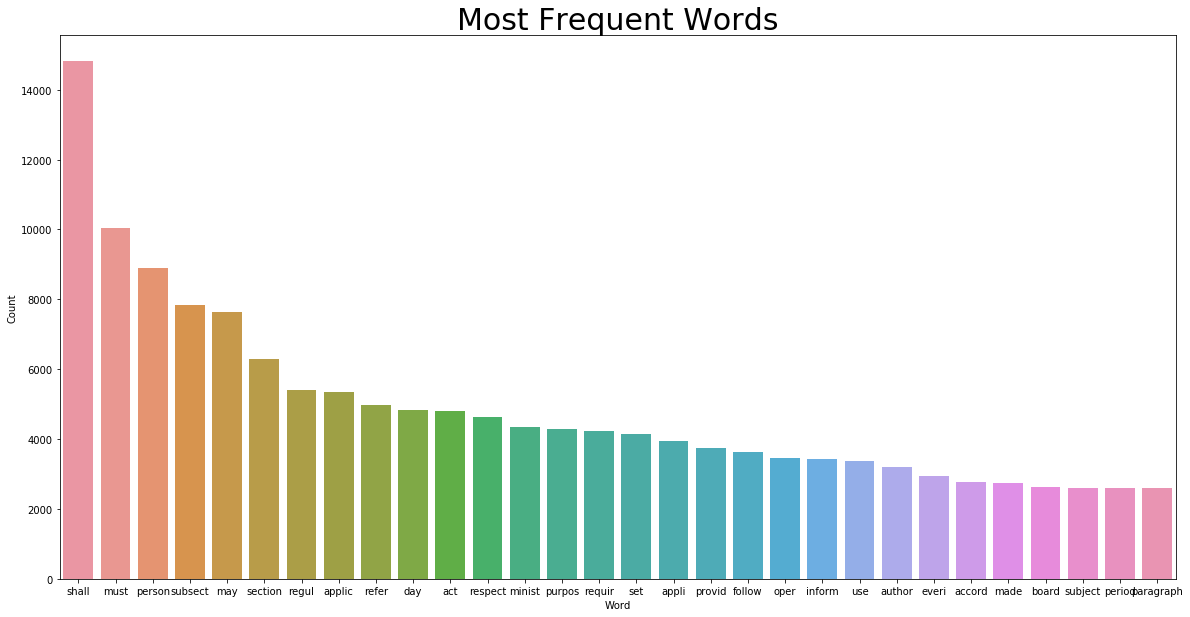

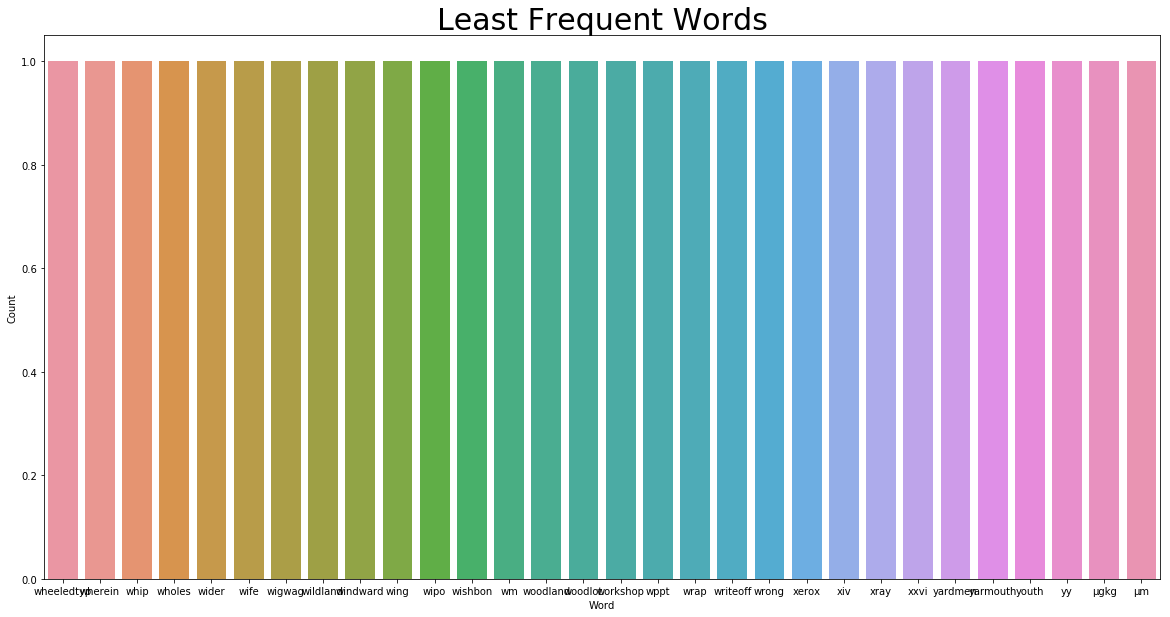

In [32]:
# Visualizing the count of most and least frequent words
df_words = pd.DataFrame(word_count, columns=['Word','Count'])

fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x='Word',y='Count', data=df_words.head(30))
plt.title('Most Frequent Words', size=30)

fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x='Word',y='Count', data=df_words.tail(30))
plt.title('Least Frequent Words', size=30)

In [33]:
#How many words show up once?
print(len(df_words[df_words['Count']==1]))
df_words[df_words['Count']==1]

1671


,Word,Count
5841,ab,1
5842,abey,1
5843,ablat,1
5844,aboard,1
5845,abreast,1
5846,abstain,1
5847,abstent,1
5848,abut,1
5849,academi,1
5850,accret,1


Text(0,0.5,'How Many Words')

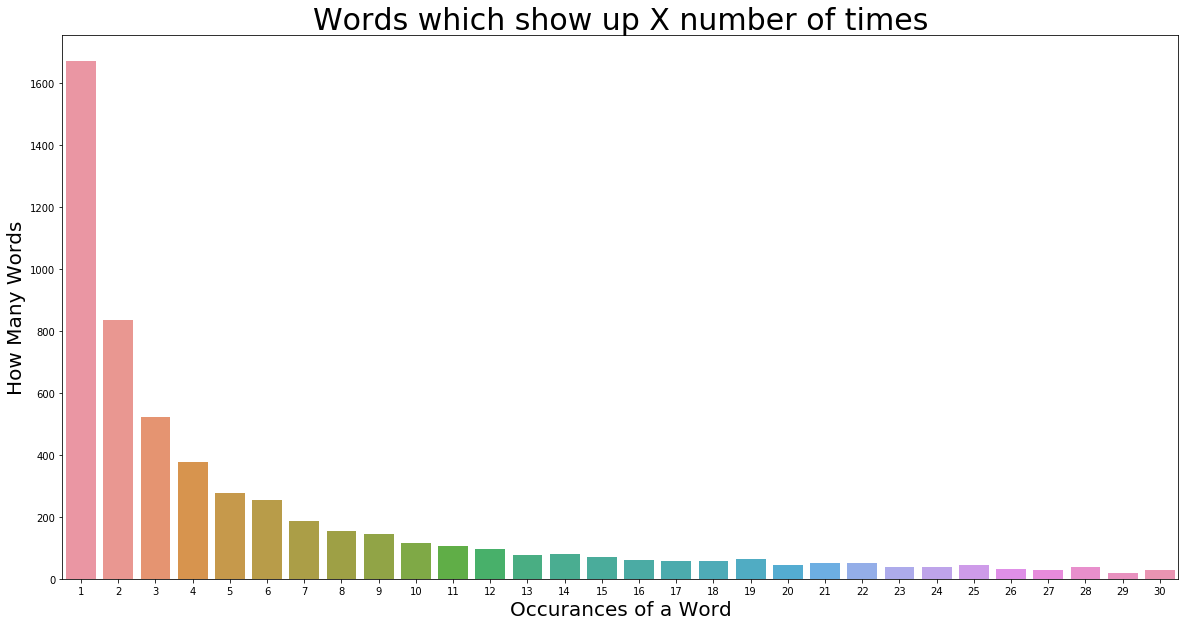

In [34]:
#Of the least freqently occuring words, how many show up X number of times?
#### Example, ~1600 different words appear only once in the entire sparse matrix

df_freq = df_words.groupby('Count').count().reset_index()

fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x='Count',y='Word', data=df_freq.head(30))
plt.title('Words which show up X number of times', size=30)
plt.xlabel('Occurances of a Word', size=20)
plt.ylabel('How Many Words', size=20)

##### Removing Frequently Occuring Words & Words Which Only Appear Once

In [35]:
high_freq_words = list(df_words['Word'][0:15])

In [36]:
df_sparse = df_sparse.drop(columns=high_freq_words)

In [37]:
low_freq_words = list(df_words[df_words['Count']==1]['Word'])

In [38]:
df_sparse = df_sparse.drop(columns=low_freq_words)

In [39]:
df_sparse.shape

(2274, 5826)

In [47]:
cols = df_sparse.columns

## Latent Semantic Analysis

In [42]:
from sklearn.decomposition import TruncatedSVD

In [53]:
lsa = TruncatedSVD(n_components = 100, random_state=0)

In [64]:
dtm_lsa = lsa.fit_transform(df_sparse)

In [66]:
from sklearn.preprocessing import Normalizer
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [67]:
#What are the top components of each concept?
for i, comp in enumerate(lsa.components_):
    terms_in_comp = zip(cols,comp)
    sorted_terms = sorted(terms_in_comp, key=lambda x: x[1], reverse=True)[:10]
    print('Concept %d:' %i)
    
    for term in sorted_terms:
        print(term[0])
    print (' ')



Concept 0:
use
oper
set
explos
vessel
follow
provid
everi
appli
licenc
 
Concept 1:
explos
licenc
store
unit
firework
seller
author
factori
sale
ignit
 
Concept 2:
plan
invest
particular
year
suppli
made
period
amount
financi
institut
 
Concept 3:
food
set
vessel
product
column
certif
label
prepackag
appli
grade
 
Concept 4:
vessel
certif
dive
oper
master
board
ensur
plan
voyag
supervisor
 
Concept 5:
dive
oper
supervisor
offic
conduct
record
claim
diver
document
parti
 
Concept 6:
plan
invest
food
dive
product
year
financi
particular
oper
institut
 
Concept 7:
suppli
dive
properti
consider
part
becom
due
tax
servic
amount
 
Concept 8:
system
instal
platform
everi
design
fire
tank
ga
accord
restraint
 
Concept 9:
categori
hazard
classifi
mixtur
accord
class
follow
dive
provid
substanc
 
Concept 10:
record
claim
mine
leas
permit
accord
follow
land
set
cost
 
Concept 11:
standard
column
set
energyus
energi
effici
employ
manufactur
test
cross
 
Concept 12:
produc
licens
marihuana
cannabi


# Document Similarity Using LSA

In [70]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(dtm_lsa) * np.asmatrix(dtm_lsa).T)
regs = list(dataset['instrument_number'])
df_regs_compare = pd.DataFrame(similarity,index=regs, columns=regs)

In [71]:
df_regs_compare

,SOR/2017-109,SOR/85-567,SOR/93-293,SOR/98-87,"C.R.C., c. 208",SOR/86-1135,"C.R.C., c. 220",SOR/2007-121,SOR/2017-121,SOR/57-216,SOR/93-522,SOR/91-74,SOR/98-50,SOR/98-44,"C.R.C., c. 1359",SOR/2011-91,SOR/82-719,SOR/2005-232,SOR/2011-170,"C.R.C., c. 591",SOR/94-562,SOR/92-296,"C.R.C., c. 778",SOR/82-296,SOR/2001-399,SOR/2012-17,SOR/92-282,SOR/2008-67,SOR/2015-36,SOR/2016-124,SOR/2001-57,SOR/2002-266,SOR/2001-428,SOR/96-117,SOR/2009-214,SOR/2009-200,SOR/86-895,SOR/95-38,SOR/2001-366,"C.R.C., c. 793","C.R.C., c. 1601",SOR/2010-161,SOR/81-235,SOR/81-547,SOR/89-421,SOR/98-168,SOR/2013-101,SOR/86-922,SOR/99-409,SOR/2007-243,SOR/99-384,"C.R.C., c. 803",SOR/2007-294,SOR/85-188,SOR/2001-206,SOR/2008-167,"C.R.C., c. 181",SOR/92-309,SOR/2002-138,SOR/83-481,SOR/99-145,"C.R.C., c. 1588",SOR/2012-138,SOR/93-481,SOR/2002-104,SOR/94-628,SOR/2006-246,"C.R.C., c. 340",SOR/2006-252,SOR/93-65,SOR/96-275,SOR/2009-162,SOR/2000-217,SOR/2004-155,"C.R.C., c. 1563",SOR/86-1082,SOR/2010-203,SOR/2000-203,SOR/2009-176,SOR/96-249,SOR/2005-353,SOR/2009-177,SOR/2000-202,SOR/2010-202,SOR/2005-347,SOR/93-325,SOR/98-380,SOR/87-701,SOR/2016-5,"C.R.C., c. 427",SOR/98-419,SOR/2004-197,"C.R.C., c. 355",SOR/2012-139,SOR/90-225,SOR/93-480,SOR/95-360,SOR/90-231,SOR/99-144,SOR/2015-145,SOR/2004-99,SOR/92-308,"C.R.C., c. 180",SOR/2005-151,"C.R.C., c. 194",SOR/87-259,SOR/2001-207,SOR/98-182,SOR/97-503,"C.R.C., c. 625",SOR/2007-242,SOR/89-408,SOR/2007-256,SOR/2010-13,SOR/81-552,SOR/95-39,"C.R.C., c. 1600",SOR/2001-401,SOR/2004-222,SOR/2009-215,"C.R.C., c. 786",SOR/2010-148,SOR/2001-429,SOR/79-818,"C.R.C., c. 751",SOR/2001-56,SOR/2012-267,SOR/2008-66,SOR/2001-398,SOR/92-283,SOR/51-84,SOR/92-297,SOR/94-563,"C.R.C., c. 90",SOR/2008-210,SOR/2000-376,"C.R.C., c. 590",SOR/2001-171,SOR/2011-90,SOR/91-49,"C.R.C., c. 1370",SOR/96-40,SOR/96-68,SOR/2003-289,SOR/97-107,SOR/91-75,SOR/93-523,"C.R.C., c. 235",SOR/2007-134,"C.R.C., c. 221",SOR/90-379,"C.R.C., c. 209",SOR/98-86,SOR/90-351,SOR/79-373,SOR/2017-108,SOR/2011-79,SOR/2006-319,SOR/2016-70,SOR/98-90,SOR/2002-11,SOR/2005-30,SOR/2003-274,"C.R.C., c. 237",SOR/95-558,SOR/91-168,"C.R.C., c. 223",SOR/2018-75,SOR/87-663,SOR/98-47,SOR/96-470,SOR/83-253,SOR/2011-86,SOR/2008-212,SOR/83-509,SOR/96-42,SOR/2011-167,SOR/99-224,SOR/90-151,SOR/92-281,SOR/2008-58,SOR/2002-265,SOR/2016-133,SOR/2008-64,SOR/2012-265,SOR/96-114,SOR/92-530,"C.R.C., c. 960",SOR/92-256,SOR/2001-403,SOR/97-449,SOR/2014-220,"C.R.C., c. 79",SOR/2001-365,"C.R.C., c. 948","C.R.C., c. 790",SOR/87-449,SOR/2009-217,SOR/2014-234,SOR/2004-220,SOR/99-350,SOR/2002-339,SOR/99-422,"C.R.C., c. 169",SOR/83-680,SOR/2003-51,SOR/2007-240,"C.R.C., c. 155",SOR/97-501,SOR/98-180,SOR/2008-158,SOR/90-794,"C.R.C., c. 182",SOR/99-13,SOR/2001-205,SOR/92-478,SOR/93-482,SOR/88-427,SOR/94-617,SOR/2000-14,SOR/2003-300,SOR/2005-392,"C.R.C., c. 343",SOR/2013-40,SOR/2012-113,SOR/2006-245,SOR/84-159,SOR/2014-181,SOR/96-276,SOR/93-441,SOR/99-191,SOR/86-262,"C.R.C., c. 1548",SOR/93-327,SOR/2005-379,SOR/2000-228,"C.R.C., c. 394",SOR/2004-156,"C.R.C., c. 1560",SOR/2000-214,"C.R.C., c. 1561","C.R.C., c. 395",SOR/2013-82,"C.R.C., c. 1575",SOR/81-948,SOR/88-397,SOR/96-277,"C.R.C., c. 1549",SOR/93-326,SOR/2006-244,...,"C.R.C., c. 1587",SOR/84-155,SOR/2004-199,SOR/94-627,SOR/2013-58,SOR/95-346,SOR/2005-375,SOR/2010-230,"C.R.C., c. 1550",SOR/2000-230,SOR/2009-145,SOR/2005–1,"C.R.C., c. 1578","C.R.C., c. 1579","C.R.C., c. 399",SOR/92-677,SOR/2010-231,SOR/2014-198,SOR/95-347,SOR/2014-44,SOR/2009-15,SOR/95-421,SOR/94-626,SOR/78-21,SOR/94-168,"C.R.C., c. 1586",SOR/2016-260,SOR/92-688,SOR/92-307,SOR/97-33,SOR/2004-96,SOR/92-313,SOR/2001-220,"C.R.C., c. 1021",SOR/2008-141,SOR/88-600,SOR/2010-20,SOR/94-356,SOR/2017-15,SOR/81-549,"C.R.C., c. 170",SOR/2013-127,SOR/2003-60,SOR/2004-69,SOR/2008-196,SOR/2017-265,"C.R.C., c. 616","C.R.C., c. 164",SOR/2004-239,SOR/97-322,SOR/95-36,SOR/2001-368,SOR/95-22,SOR/97-450,SOR/2001-432,SOR/79-817,SOR/2001-426,SOR/2004-211,SOR/2010-147,SOR/2001-59,"C.R.C., c. 992",SOR/2008-69,SOR/2012-26

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(df_regs_compare, annot=True)

## 5. Clustering

##### Number of Clusters - Elbow Method

In [218]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [237]:
wcss = []
counter = 0
for i in range (1,21):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_lsa)
    wcss.append(kmeans.inertia_)
    counter +=1

In [238]:
counter

20

Text(0,0.5,'WCSS')

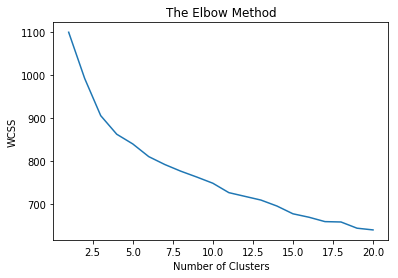

In [240]:
plt.plot(range(1,21),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

##### K-Means Clustering

In [241]:
num_clusters = 10
km = KMeans(n_clusters=num_clusters)
km.fit(df_lsa)
clusters = km.labels_.tolist()

In [242]:
len(df_sparse)

2274

In [243]:
len(clusters)

2274

In [244]:
len(dataset)

2274

In [245]:
#Updating the cluster labels to start at 1 instead of 0
for i in range(0,len(clusters)):
    clusters[i] += 1

In [246]:
dataset['Cluster'] = clusters

In [247]:
dataset['Cluster'].value_counts()

2     1185
5      293
6      168
4      147
1      143
10     115
9       95
7       65
8       57
3        6
Name: Cluster, dtype: int64

### Analyzing the Cluster Outputs

In [252]:
dataset[dataset['Cluster']==3]

,consolidation_date,enabling_authority,enabling_type,file_name,instrument_number,language,last_modified_date,order_number,registration_date,regulation_maker,regulation_provision,regulation_type,repealed,section_bodies,section_labels,title,Cluster
1434,2018-06-11,CUSTOMS TARIFF,act,Consolidation_Regs_1.2.0/EN/SOR-98-135.xml,SOR/98-135,en,2008-10-22,1998-280,1998-2-26,P.C.,His Excellency the Governor General in Council...,SOR,False,['Remission is granted pursuant to section 1 o...,"['2', '3']",Order Respecting the Remission of Anti-Dumping...,3
1502,2018-06-11,CRIMINAL CODE,act,Consolidation_Regs_1.2.0/EN/SOR-2002-63.xml,SOR/2002-63,en,2008-11-4,2002-114,2002-1-31,P.C.,Her Excellency the Governor General in Council...,SOR,False,['These Regulations come into force on Februar...,['2'],Regulations Excluding Certain Indictable Offen...,3
1833,2018-06-11,PARLIAMENT OF CANADA ACT,act,Consolidation_Regs_1.2.0/EN/SOR-98-126.xml,SOR/98-126,en,2008-10-22,Null,1998-2-19,Null,"[{'@format-ref': 'indent-0-0', '@language-alig...",SOR,False,['These Regulations come into force on Februar...,['2'],Senate Sessional Allowance (Suspension) Regula...,3
1859,2018-06-11,"CANADA SHIPPING ACT, 2001",act,Consolidation_Regs_1.2.0/EN/SOR-2000-71.xml,SOR/2000-71,en,2007-11-14,2000-217,2000-2-24,P.C.,Her Excellency the Governor General in Council...,SOR,False,['The following provisions of the do not appl...,"['2', '3']",Regulations Excluding Certain Government Ships...,3
2477,2018-06-11,PUBLIC SERVICE EMPLOYMENT ACT,act,Consolidation_Regs_1.2.0/EN/SOR-2006-36.xml,SOR/2006-36,en,2006-3-24,2006-68,2006-2-6,P.C.,Her Excellency the Governor General in Council...,SOR,False,['These Regulations come into force on Februar...,['2'],Transfer of the Crown Corporation Secretariat ...,3
3589,2018-06-11,STATE IMMUNITY ACT,act,Consolidation_Regs_1.2.0/EN/SOR-97-121.xml,SOR/97-121,en,2008-10-28,1997-242,1997-2-18,P.C.,"[{'@format-ref': 'indent-0-0', '@language-alig...",SOR,False,"['This Order comes into force on February 18, ...",['2'],Order Restricting Certain Immunity In Relation...,3
